## Import Library

In [93]:
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter
import re
from nltk import ngrams

## Load Data Set

In [94]:
df = pd.read_csv('DataSet.csv')

In [95]:
sample_df = df.sample(n=100, random_state=42)

In [96]:
fraud_df = df[df['fraudulent'] == 't'].copy() # filter fraudulent jobs. i.e. keep rows with fraudulent = t

In [97]:
fraud_df.to_csv('fraudulent_jobs_sample.csv', index=False)

In [98]:
non_fraud_df = df[df['fraudulent'] == 'f'].copy() # filter non-fraudulent jobs. i.e. keep rows with fraudulent = f

## 1. Inspecting the structure of Dataset

In [99]:
# Seeing the first few rows of the dataframe
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f


In [100]:
# Inspecting the structure of Dataset
print("Shape:", df.shape) # 17880 records, 18 columns
print("\nData Types:\n", df.dtypes) # All columns are object type

Shape: (17880, 18)

Data Types:
 title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting          object
has_company_logo       object
has_questions          object
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent             object
in_balanced_dataset    object
dtype: object


In [101]:
print("length of fraudulent jobs:", len(fraud_df)) # 866 fraudulent job ads
print("length of non-fraudulent jobs:", len(non_fraud_df)) # 17014 non-fraudulent job ads

length of fraudulent jobs: 866
length of non-fraudulent jobs: 17014


The dataset is imbalanced, with 866 fraudulent job postings and 17,014 non-fraudulent ones. However, this imbalance reflects real-world conditions. Legitimate job ads far outnumber scams, which is typical in fraud detection scenarios.

After careful consideration, no balancing is needed. In fact, preserving the imbalance is beneficial, as it maintains the true distribution of data and supports realistic analysis.

Instead of focusing on raw counts, the analysis emphasizes comparative proportions (e.g., the percentage of fraudulent vs. legitimate ads containing specific red flags). This approach will ensure meaningful insights while avoiding biased assumptions about scam prevalence.

### Clean the dataset

1. To normalize all fields and combine the job ad columns into one column. Job postings are spread across multiple columns in inconsistent formats. Combining them into a single text field ensures complete, unified content for analysis, enabling full-text pattern matching and reducing the risk of missing critical signals.<br>

2. Remove HTML tags, normalize whitespace, remove whitespace, replace empty fields with empty strings. reduce noise and improve the accuracy of text-based feature extraction. <br>


3. Replace empty strings as No-Content. Prevents NaN or empty strings from causing errors in downstream processing. Makes it easier to flag missingness as a potential scam signal 

In [102]:
def clean_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text().strip() # Remove HTML tags and extra whitespace

In [103]:
def clean_df(df_orig):
    df_clean = df_orig.copy()
    
    # Replace NaN and string 'nan'
    df_clean = df_clean.fillna('').replace('nan', '', regex=False)
    
    # Remove placeholder tags
    df_clean = df_clean.replace(r'#URL_[a-f0-9]+#|#PHONE_[a-f0-9]+#|#EMAIL_[a-f0-9]+#', '', regex=True)
    
    # Combine all columns
    df_clean['text'] = df_clean.astype(str).agg(' '.join, axis=1)
    
    # Clean HTML and normalize
    df_clean['text_clean'] = df_clean['text'].apply(clean_html)
    df_clean['text_clean'] = df_clean['text_clean'].str.replace(r'\s+', ' ', regex=True)          # Normalize whitespace
    df_clean['text_clean'] = df_clean['text_clean'].str.replace(r'[^\w\s]', '', regex=True)      # Remove punctuation
    df_clean['text_clean'] = df_clean['text_clean'].str.strip()
    df_clean['text_clean'] = df_clean['text_clean'].replace('', 'No content')
    
    return df_clean

In [104]:
# Apply to all
df = clean_df(df)
fraud_df = clean_df(fraud_df)
non_fraud_df = clean_df(non_fraud_df)

In [105]:
'''
#cleaning non-fraudulent dataframe
non_fraud_df = non_fraud_df.fillna('')  # Replaces real NaN
fraud_df = fraud_df.replace('nan', '', regex=False)  # Replaces string 'nan'

# Remove placeholder tags
fraud_df = fraud_df.replace(r'#URL_[a-f0-9]+#|#PHONE_[a-f0-9]+#|#EMAIL_[a-f0-9]+#', '', regex=True)

# Combine all columns into one text field
fraud_df['text'] = fraud_df.astype(str).agg(' '.join, axis=1)

# Clean HTML and normalize
fraud_df['text_clean'] = fraud_df['text'].apply(clean_html)
fraud_df['text_clean'] = fraud_df['text_clean'].str.replace(r'\s+', ' ', regex=True)  # Normalize whitespace
fraud_df['text_clean'] = fraud_df['text_clean'].str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
fraud_df['text_clean'] = fraud_df['text_clean'].str.strip()

# Handle fully empty entries
fraud_df['text_clean'] = fraud_df['text_clean'].replace('', 'No content')
'''

"\n#cleaning non-fraudulent dataframe\nnon_fraud_df = non_fraud_df.fillna('')  # Replaces real NaN\nfraud_df = fraud_df.replace('nan', '', regex=False)  # Replaces string 'nan'\n\n# Remove placeholder tags\nfraud_df = fraud_df.replace(r'#URL_[a-f0-9]+#|#PHONE_[a-f0-9]+#|#EMAIL_[a-f0-9]+#', '', regex=True)\n\n# Combine all columns into one text field\nfraud_df['text'] = fraud_df.astype(str).agg(' '.join, axis=1)\n\n# Clean HTML and normalize\nfraud_df['text_clean'] = fraud_df['text'].apply(clean_html)\nfraud_df['text_clean'] = fraud_df['text_clean'].str.replace(r'\\s+', ' ', regex=True)  # Normalize whitespace\nfraud_df['text_clean'] = fraud_df['text_clean'].str.replace(r'[^\\w\\s]', '', regex=True)  # Remove punctuation\nfraud_df['text_clean'] = fraud_df['text_clean'].str.strip()\n\n# Handle fully empty entries\nfraud_df['text_clean'] = fraud_df['text_clean'].replace('', 'No content')\n"

To enable effective analysis, all columns in the dataset were combined into a single `clean_text` field for each job advertisement. This step was critical, as the original data was semi-structured and spread across multiple columns with embedded HTML.

By consolidating content into one column, we ensure that:
- Scattered job details are preserved together
- HTML fragments are kept intact for full-context analysis
- Pattern detection via keyword matching, duplication is consistent and comprehensive

The resulting `clean_text` column provides a unified view of each job ad, enabling more accurate identification of linguistic and structural red flags such as urgency cues, vague claims, and template reuse that are common in fraudulent postings.

In summary, this consolidation simplifies downstream processing and strengthens the ability to detect potential scam patterns across the dataset.

## What makes a job ad look like a scam?

1. Check for duplicate entries.
2. Compare with non-fraudulent jobs.
3. Seive out commonly-used
3. Extract Suspicious Phrases

### Check for duplicate entries

Repetitive or duplicated job advertisements may indicate fraudulent activity, as scammers often reuse templates across multiple postings to maximize reach with minimal effort. <br>

Checking for recurring/ duplicated job advertisement could be associated with the job advertisement being fraudulent. <br>

Therefore, we can prepare the data & run a chi-square test to check for correlation between duplicated job postings and that job posting being fraudulent. <br>

**Null Hypothesis**: There is no association between a job ad being duplicated and it being fraudulent. <br>
**Alternative Hypothesis**: Duplicated job ads are more likely to be fraudulent. <br>

If the p-value is below 0.05, we reject the null hypothesis and conclude that duplication is significantly associated with fraudulent postings. <br>

**Note**: While duplication can be a useful signal, legitimate companies may also repost jobs. The goal is to determine whether duplication is more frequent among scams, not to assume all duplicates are fraudulent.

In [106]:
# Check for how many fraudulent jobs and duplicates
print("Total fraudulent jobs:", len(fraud_df))
print("Duplicate text entries:", fraud_df['text_clean'].duplicated().sum()) # count the number of 'true' in the series

# check for how many jobs have duplicates
print("\nTotal Jobs:", len(df))
print("All Jobs with Duplicates:", df['text_clean'].duplicated().sum()) # count the number of 'true' in the series

#Percentage of duplicate jobs are fraudulent
percentage_duplicate_fraud = (fraud_df['text_clean'].duplicated().sum() / df['text_clean'].duplicated().sum()) * 100
print("\nPercentage of duplicate jobs that are fraudulent: {:.2f}%".format(percentage_duplicate_fraud))

Total fraudulent jobs: 866
Duplicate text entries: 8

Total Jobs: 17880
All Jobs with Duplicates: 330

Percentage of duplicate jobs that are fraudulent: 2.42%


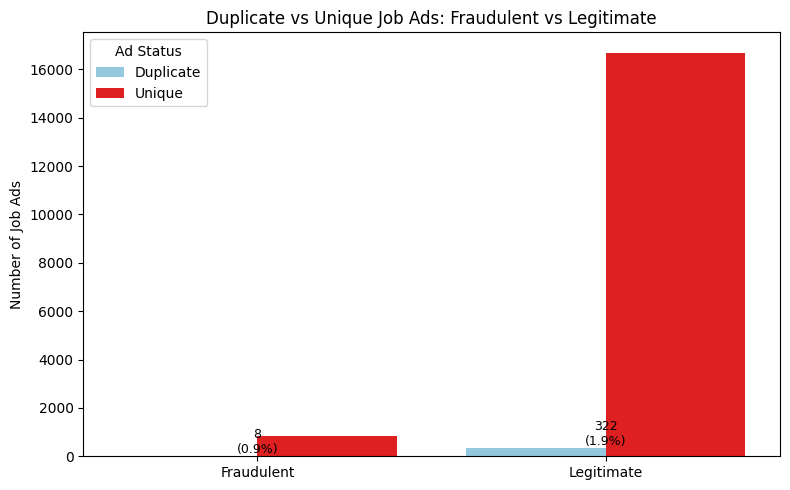

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

dup_count_fraud = fraud_df['text_clean'].duplicated().sum()
dup_count_legit = non_fraud_df['text_clean'].duplicated().sum()
total_fraud = len(fraud_df)
total_legit = len(non_fraud_df)
unique_count_fraud = total_fraud - dup_count_fraud
unique_count_legit = total_legit - dup_count_legit
data = pd.DataFrame({
    'Job Type': ['Fraudulent', 'Legitimate'],
    'Duplicate': [dup_count_fraud, dup_count_legit],
    'Unique': [unique_count_fraud, unique_count_legit]
})

# Melt for seaborn
data_melted = data.melt(id_vars='Job Type', value_vars=['Duplicate', 'Unique'], 
                        var_name='Status', value_name='Count')

# Plot using seaborn
plt.figure(figsize=(8, 5))
barplot = sns.barplot(data=data_melted, x='Job Type', y='Count', hue='Status', palette=['skyblue', 'red'])
plt.title('Duplicate vs Unique Job Ads: Fraudulent vs Legitimate')
plt.ylabel('Number of Job Ads')
plt.xlabel('')
plt.legend(title='Ad Status')

# Add percentage labels using numeric x positions
for i, job_type in enumerate(['Fraudulent', 'Legitimate']):
    dup_val = data.loc[data['Job Type'] == job_type, 'Duplicate'].values[0]
    uniq_val = data.loc[data['Job Type'] == job_type, 'Unique'].values[0]
    total = dup_val + uniq_val
    pct = dup_val / total if total > 0 else 0
    plt.text(i, dup_val + 2, f"{dup_val}\n({pct:.1%})", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# plot contingency table for duplicates in fraudulent vs legitimate jobs
dup_count_fraud = fraud_df['text_clean'].duplicated().sum() 
dup_count_legit = df[df['fraudulent'] == 'f']['text_clean'].duplicated().sum()  
total_fraud = len(fraud_df)
total_legit = len(df[df['fraudulent'] == 'f'])
contingency = pd.DataFrame({
    'Fraudulent': [dup_count_fraud, total_fraud - dup_count_fraud],
    'Legitimate': [dup_count_legit, total_legit - dup_count_legit]
}, index=['Duplicate', 'Unique'])

print(contingency)

           Fraudulent  Legitimate
Duplicate           8         322
Unique            858       16692


In [17]:
# perform Chi-squared test
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency)
print("p-value:", p)

p-value: 0.05277121187974043


**Conclusion**
>p-value is 0.0527 (>0.05). We do not have sufficient evidence to reject the null hypothesis that there is no association between a job ad being duplicated and it being fraudulent.

In [18]:
print("\nTop 5 repeated job descriptions:", df['text_clean'].value_counts().head(5))

print("\nTop 5 repeated fraudulent job descriptions:", fraud_df['text_clean'].value_counts().head(5))

print("\nTop 5 repeated non-fraudulent job descriptions:", non_fraud_df['text_clean'].value_counts().head(5))


Top 5 repeated job descriptions: text_clean
Mirfield Warehousing Apprenticeship Under NAS 1618 Year Olds Only GB  Mirfield Established on the principles that full time education is not for everyone Spectrum Learning is made up of a team of passionate consultants with the drive for putting people who wish to grow themselves through education whilst working into long term and relevant job roles We also are official resellers for The Institute of Recruiters Study Course professional courses in HR Practice InHouse Recruitment and Agency Recruitment It is our mission to help anyone wishing to pursue an apprenticeship onto the right qualification and into the right job We work closely with both the candidate and the employer to ensure when the learner is enrolled they are at the start of a long and successful career We have great relationships with a number of national training providers to ensure we can cover any apprenticeship available Government funding is only available for 1618 year o

Analysis revealed 247 duplicate job descriptions out of 17,880 total entries, indicating a possible widespread re-use of templates. The top 5 job descriptions are as the above listed, and have been duplicated for 4-6 times in total. <br> 

However, this duplicate in job advertisement cannot be a strong indicator or recurring pattern that the job advertisement is fraudulent. <br>

### Quality of Data

#### Check for missing data in each column

In [19]:
missing_data = df.isin(['', ' ', 'nan', 'None']).sum() + df.isnull().sum()
print("Missing values per column:\n", missing_data)

missing_fraudulent_data = fraud_df.isin(['', ' ', 'nan', 'None']).sum() + fraud_df.isnull().sum()
print("\nMissing values per column in fraudulent jobs:\n", missing_fraudulent_data)

missing_non_fraudulent_data = non_fraud_df.isin(['', ' ', 'nan', 'None']).sum() + non_fraud_df.isnull().sum()
print("\nMissing values per column in non-fraudulent jobs:\n", missing_non_fraudulent_data)

Missing values per column:
 title                      0
location                 346
department             11553
salary_range           15012
company_profile         3308
description                0
requirements            2689
benefits                7196
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
in_balanced_dataset        0
text                       0
text_clean                 0
dtype: int64

Missing values per column in fraudulent jobs:
 title                    0
location                19
department             531
salary_range           643
company_profile        587
description              0
requirements           153
benefits               363
telecommuting            0
has_company_logo         0
has_questions            0
employment_type        241
require

An analysis of missing values across job advertisement fields reveals significant data gaps, particularly in key informational fields.

Fields with high missingness include:
- **`salary_range`**: 15,012 missing (84.5% of all jobs)
- **`department`**: 11,553 missing
- **`required_education`**: 8,105 missing
- **`benefits`**: 7,196 missing

In contrast, core descriptive fields like `title`, `description` have no missing values, indicating they are consistently provided across postings.

This pattern suggests that while basic content is present, critical job details are frequently omitted. A behavior often seen in low-effort or potentially fraudulent postings. Scammers may intentionally leave out accountability-rich information (e.g., salary, education requirements) to avoid scrutiny or mislead applicants.

Notably, **fraudulent jobs show higher rates of missingness** in fields like `company_profile` (587 vs. 2,721 in legitimate jobs — but proportionally more common among scams) and `salary_range`, reinforcing the idea that **missingness itself can be a behavioral signal**.

> **Insight**: While not all incomplete ads are scams, **a high number of missing fields increases suspicion**. Our detection strategy should flag job ads with excessive missing information — especially when combined with other red flags like urgency or "no experience" language.

**Next Steps**: To perform qualitative analysis via Data Visualization of the sparsity of data in each fields and quantitative analysis by comparing the percentage of missing datas between legitimate and fraudulent data.
We will also run a chi-square test to check if the missing fields are independent of fraudulent job ads.
This is important as it helps us to identify the key indicators that would pose higher risk to job scams.

##### Visualization of sparsity of data

1. Plot a heatmap for visualizing missing data in the dataset. <br>
2. Large white blocks indicate missing data. If there are several of fields appear as white blocks per row, this indicates low data quality of the record. <br> 
3. However, such data should not be excluded in our analysis as if many key fields are missing, it is often a scam signal of that particular job listing.
4. This visually highlights the critical details/signals/fields that scam ads often could lack to appear legitimate, allowing us to identify these fields as a potential red flag for fraud detection

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

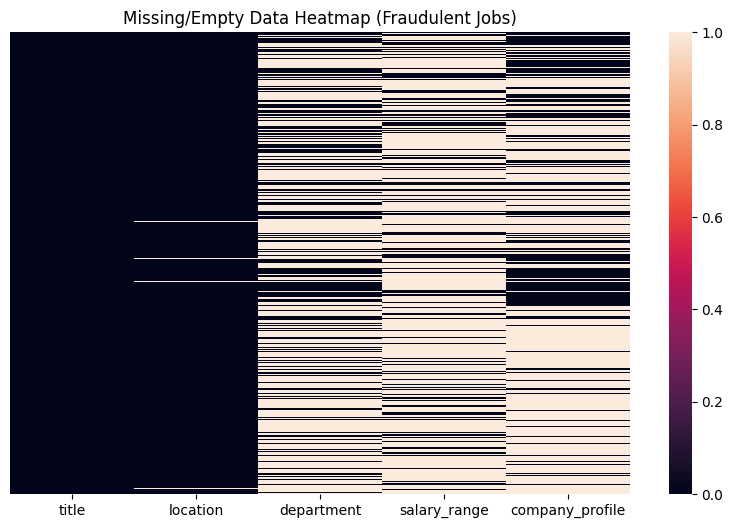

In [21]:
# fraudulent data missing data heatmap
data_for_heatmap_fraud = fraud_df.iloc[:, :-15]
plt.figure(figsize=(10, 6))
sns.heatmap(data_for_heatmap_fraud.astype(str).replace(['', 'nan', 'None'], np.nan).isnull(), cbar=True, yticklabels=False)
plt.title("Missing/Empty Data Heatmap (Fraudulent Jobs)")
plt.show()

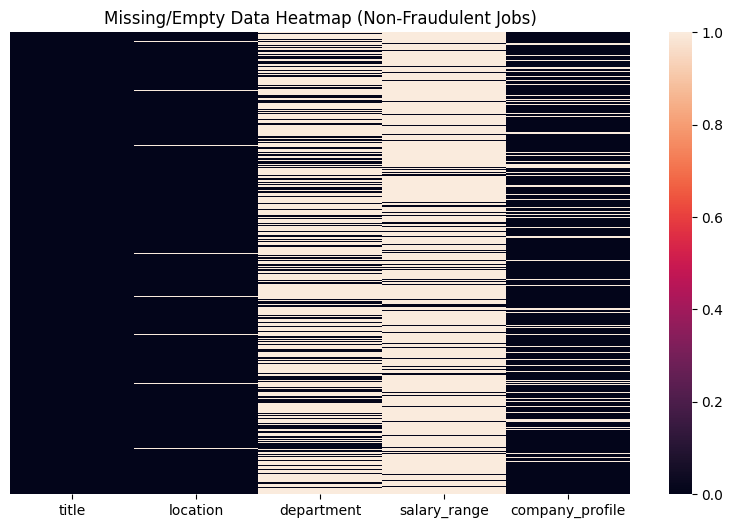

In [22]:
# non-fraudulent data missing data heatmap
data_for_heatmap_non_fraud = non_fraud_df.iloc[:, :-15]
plt.figure(figsize=(10, 6))
sns.heatmap(data_for_heatmap_non_fraud.astype(str).replace(['', 'nan', 'None'], np.nan).isnull(), cbar=True, yticklabels=False)
plt.title("Missing/Empty Data Heatmap (Non-Fraudulent Jobs)")
plt.show()

A visual comparison of missing data between fraudulent and non-fraudulent job ads reveals a striking pattern: **fraudulent postings exhibit significantly higher missingness in key fields**, particularly `company_profile`.

The heatmap below visualizes missing or empty values across job ad fields, highlighting systematic gaps in critical information. Fields such as `salary_range`, `department`, and `required_education` show high levels of incompleteness. This could be a hallmark of low-effort or potentially deceptive postings.

This pattern suggests that scammers often omit accountability-rich details to avoid scrutiny, making **missingness itself a potential red flag** for fraud detection.

However, not all missing fields are equally indicative of fraud. To identify the most **discriminative signals**, we need to move beyond visual inspection and perform a **quantitative analysis**:

1. **Compare missingness rates**: Compute the percentage of missing values in each field, separately for fraudulent and legitimate jobs.
2. **Statistical validation**: Conduct chi-square tests of independence to determine which missing fields are **significantly associated** with fraud.

This two-step approach ensures that our detection system is based on **evidence**, not just intuition. This focuses only on fields where missingness is a statistically meaningful indicator of scam behavior.

In [23]:
fields = ['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

In [24]:
# % of missing 'field_name' in fraudulent vs legitimate jobs

for field in fields:
    percentage_missing_fraud = missing_fraudulent_data[field] / len(fraud_df)
    percentage_missing_legit = missing_non_fraudulent_data[field] / len(non_fraud_df)
    print(f"Missing '{field}' - Fraudulent: {percentage_missing_fraud:.1%}")
    print(f"Missing '{field}' - Legitimate: {percentage_missing_legit:.1%}")
    print(f'Difference: {percentage_missing_fraud - percentage_missing_legit:.1%}')
    print()  


Missing 'title' - Fraudulent: 0.0%
Missing 'title' - Legitimate: 0.0%
Difference: 0.0%

Missing 'location' - Fraudulent: 2.2%
Missing 'location' - Legitimate: 1.9%
Difference: 0.3%

Missing 'department' - Fraudulent: 61.3%
Missing 'department' - Legitimate: 64.8%
Difference: -3.5%

Missing 'salary_range' - Fraudulent: 74.2%
Missing 'salary_range' - Legitimate: 84.5%
Difference: -10.2%

Missing 'company_profile' - Fraudulent: 67.8%
Missing 'company_profile' - Legitimate: 16.0%
Difference: 51.8%

Missing 'description' - Fraudulent: 0.0%
Missing 'description' - Legitimate: 0.0%
Difference: 0.0%

Missing 'requirements' - Fraudulent: 17.7%
Missing 'requirements' - Legitimate: 14.9%
Difference: 2.8%

Missing 'benefits' - Fraudulent: 41.9%
Missing 'benefits' - Legitimate: 40.2%
Difference: 1.8%

Missing 'telecommuting' - Fraudulent: 0.0%
Missing 'telecommuting' - Legitimate: 0.0%
Difference: 0.0%

Missing 'has_company_logo' - Fraudulent: 0.0%
Missing 'has_company_logo' - Legitimate: 0.0%
Diff

Using quantitative analysis, it could be seen that fraudulent job advertisements tend to have more missing `company_profile`, `requirements`, `benefits`, `employment_type`, `required_experience`, `required_education`, `industry`, `function` fields. Hence, these are indicators/ red flag that the job advertisement is a scam. <br>

However, to assess whether this association is statistically significant, we perform a **Chi-Square Test of Independence**.

#### Hypotheses
- **Null Hypothesis:** There is no association between missing `<<FIELD_NAME>>` and a job ad being fraudulent.
- **Alternative Hypothesis:** Missing `<<FIELD_NAME>>` is associated with a higher likelihood of fraud.


In [25]:
from scipy.stats import chi2_contingency

# formula for chi-square test for independence
def calculate_chi_square(field):
    missing_fraud = missing_fraudulent_data[field]    
    total_fraud = len(fraud_df)                                
    missing_legit = missing_non_fraudulent_data[field]  
    total_legit = len(non_fraud_df)                            

    # Build contingency table
    contingency = pd.DataFrame({
        'Fraudulent': [missing_fraud, total_fraud - missing_fraud],
        'Legitimate': [missing_legit, total_legit - missing_legit]
    }, index=['Missing', 'Present'])

    print(f"Contingency Table for {field}:")
    print(contingency)

    # Run chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency)
    return p

In [26]:
studied_fields = ['company_profile', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
p_values = {}

for field in studied_fields:
    p_values[field] = calculate_chi_square(field)
    #print(p_values[field])
    
significant_fields = {}
for key, value in p_values.items():
    if value < 0.05:
        significant_fields[key] = value

print("\nFields with statistically significant association (p < 0.05):", significant_fields)

Contingency Table for company_profile:
         Fraudulent  Legitimate
Missing         587        2721
Present         279       14293
Contingency Table for requirements:
         Fraudulent  Legitimate
Missing         153        2536
Present         713       14478
Contingency Table for benefits:
         Fraudulent  Legitimate
Missing         363        6833
Present         503       10181
Contingency Table for employment_type:
         Fraudulent  Legitimate
Missing         241        3230
Present         625       13784
Contingency Table for required_experience:
         Fraudulent  Legitimate
Missing         435        6615
Present         431       10399
Contingency Table for required_education:
         Fraudulent  Legitimate
Missing         451        7654
Present         415        9360
Contingency Table for industry:
         Fraudulent  Legitimate
Missing         275        4628
Present         591       12386
Contingency Table for function:
         Fraudulent  Legitimate
M

For the missing fields `comapny_profile`, `requirements`, `employment_type`, `required_experience`, `required_education`, `industry`, the p-value is far below 0.05, so we reject the null hypothesis. There is a statistically significant association between missing these fields and job ad fraud.

This supports the use of missing {`comapny_profile`, `requirements`, `employment_type`, `required_experience`, `required_education`, `industry`} fields as a high-value red flag in scam detection systems. While not all such jobs are scams, this feature can help prioritize high-risk posts for review.

### Identifying Recurring Words and Phrases in Fraudulent Job Ads

This section aims to uncover **commonly used words and phrases** in fraudulent job advertisements by comparing their usage patterns against legitimate job postings. 

The goal is to:
- Identify **recurring linguistic patterns** in scam ads
- Quantify the **likelihood (probability)** of specific terms appearing in fraudulent vs. legitimate jobs
- Highlight **discriminative signals** that can serve as red flags for scam detection

By analyzing language at the word and phrase level, we seek to expose the "fingerprint" of job scams. Such as overuse of urgency, vague promises, or low-barrier entry requirements. That distinguish them from genuine opportunities.

In [27]:
def get_word_counts(text_series):
    word_counter = Counter()
    word_pattern = re.compile(r'\b[a-z]{3,}\b')  # words with 3+ letters
    
    for text in text_series.dropna():  # Iterate row by row
        words = word_pattern.findall(text.lower())
        word_counter.update(words)
    
    return word_counter

In [28]:
# Get word counts
fraud_words = get_word_counts(fraud_df['text_clean'])
non_fraud_words = get_word_counts(non_fraud_df['text_clean'])

# Total number of job ads in each group
N_fraud = len(fraud_df)
N_legit = len(non_fraud_df)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Extract words from each ad (already cleaned)
def extract_words(text):
    return set(re.findall(r'\b[a-z]{3,}\b', text))  # Use set to avoid duplicates per ad

# Apply to both groups
fraud_df['words'] = fraud_df['text_clean'].apply(extract_words)
non_fraud_df['words'] = non_fraud_df['text_clean'].apply(extract_words)

# Combine texts
fraud_texts = fraud_df['text_clean'].tolist()
non_fraud_texts = non_fraud_df['text_clean'].tolist()

# Step 2: Build global vocabulary
all_words = set()
all_words.update(word for words in fraud_df['words'] for word in words)
all_words.update(word for words in non_fraud_df['words'] for word in words)

# Remove common stop words 
stop_words = [
    'job', 'jobs', 'work', 'will', 'role', 'team', 'company', 'skills', 'skill',
    'experience', 'required', 'requirements', 'position', 'candidate', 'must',
    'one', 'also', 'able', 'using', 'data', 'marketing', 'information', 'field',
    'entry', 'level', 'full', 'time', 'part', 'remote', 'home', 'service', 'good'
]
all_words = {w for w in all_words if w not in stop_words}

# Fit vectorizer
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words=stop_words,
    token_pattern=r'\b[a-z]{3,}\b'
)

# Fit on all texts
all_texts = fraud_texts + non_fraud_texts
X = vectorizer.fit_transform(all_texts)

X_fraud = X[:len(fraud_texts)]
X_legit = X[len(fraud_texts):]


feature_names = vectorizer.get_feature_names_out()

# Count how many ads contain each word 
word_analysis = []
for i, word in enumerate(feature_names):
    fraud_count = X_fraud[:, i].getnnz()  # number of non-zero meaning contains word
    legit_count = X_legit[:, i].getnnz()
    
    p_fraud = fraud_count / X_fraud.shape[0]
    p_legit = legit_count / X_legit.shape[0]
    
    diff = p_fraud - p_legit
    ratio = p_fraud / p_legit if p_legit > 0 else 999
    
    word_analysis.append({
        'word': word,
        'p_fraud': round(p_fraud, 4),
        'p_legit': round(p_legit, 4),
        'diff': round(diff, 4),
        'ratio': round(ratio, 2) if ratio != 999 else 999
    })

word_df = pd.DataFrame(word_analysis)

In [40]:
# Sort by biggest difference (p_fraud - p_legit)
word_df_sorted = word_df.sort_values('diff', ascending=False)

print("Top Words Strongly Associated with Fraudulent Job Ads:")
print(word_df_sorted[['word', 'p_fraud', 'p_legit', 'diff', 'ratio']].head(30))

Top Words Strongly Associated with Fraudulent Job Ads:
                 word  p_fraud  p_legit    diff  ratio
38879             per   0.2794   0.1133  0.1662   2.47
16133            earn   0.1582   0.0175  0.1407   9.03
47236          school   0.2910   0.1565  0.1345   1.86
17071      encouraged   0.1432   0.0115  0.1317  12.49
856    administrative   0.1928   0.0680  0.1248   2.84
36505             oil   0.1409   0.0215  0.1194   6.57
50741        staffing   0.1559   0.0417  0.1142   3.74
34829          needed   0.2506   0.1365  0.1141   1.84
11576       corporate   0.1801   0.0716  0.1086   2.52
3058             area   0.2125   0.1045  0.1080   2.03
24500         houston   0.1085   0.0156  0.0930   6.97
17872      equivalent   0.2945   0.2022  0.0922   1.46
5188         benefits   0.3522   0.2613  0.0909   1.35
55810          typing   0.1005   0.0101  0.0904  10.00
16010          duties   0.2425   0.1524  0.0901   1.59
2662       applicable   0.1674   0.0822  0.0852   2.04
17169     

### Interpretation of Top Words in Fraudulent Job Ads

This analysis identifies words that are significantly more common in fraudulent job advertisements compared to legitimate ones. By comparing the probability of word occurrence (`p_fraud` vs. `p_legit`), we uncover linguistic patterns that distinguish scams from genuine opportunities.

#### Key Findings

Fraudulent job advertisements tend to have higher probability of using these words: `earn`, `encouraged` , `oil`, `typing` , `houston` , `clerk`, `clerical`,`relocation`

#### Notable Patterns

1. **Low-Skill, Entry-Level Roles**  
   Words like `"clerk"`, `"clerical"`, `"typing"`, and `"administrative"` suggest scammers target entry-level job seekers with promises of easy work and fast income.

2. **Urgency and Persuasion**  
   High-ratio words like `"encouraged"`, `"participate"`, and `"apply"` possibly indicate emotional manipulation. This could be common in scams that pressure applicants to act quickly.

3. **Geographic Targeting**  
   `"Houston"` appears disproportionately in fraud ads, possibly indicating localized scam campaigns or fake postings targeting specific regions.

4. **Misuse of Corporate Jargon**  
   Terms like `"corporate"`, `"leveraging"`, `"staffing"`, and `"relocation"` are used in a vague, buzzword-like manner which mimicks professional language without substance.
   
5. **Income Promises**  
   `"Earn"`, `"bonuses"`, and `"benefits"` are more frequent in scams, often paired with overpromising.

6. **Suspicious Application Methods**  
   `"Email"` and `"via"` may indicate **non-standard application processes** (e.g., “email your resume to...”).

#### Surprising Observations

- `"Benefits"` and `"payroll"` are more common in scams. This is possibly used to create false legitimacy.
- `"Oil"`, `"energy"`, `"gas"`. these reflect template reuse from real job ads in the energy sector, but are likely copy-pasted into scam postings.
- `"Per"`, `"needed"`, `"duties"`. These are generic words with high frequency in scams, suggesting template-based writing.

#### Conclusion

While no single word is a definitive scam signal, the **combination** of:
- Low-skill terms (`clerk`, `typing`)
- Emotional cues (`encouraged`, `participate`)
- Income promises (`earn`, `bonuses`)
- Vague corporate language (`leveraging`, `staffing`)
forms a **distinct linguistic fingerprint** of job scams.

As part of identifying scam job advertisements,  it is recommended to use these high-difference, high-ratio words as red flags in a rule-based or scoring system. Prioritize words with both high `diff` (>0.08) and high `ratio` (>5), such as `"clerk"`, `"typing"`, `"earn"`, and `"encouraged"`.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Combine texts
fraud_texts = fraud_df['text_clean'].tolist()
legit_texts = non_fraud_df['text_clean'].tolist()

# Use CountVectorizer to extract 3-grams (3-word phrases)
vectorizer = CountVectorizer(
    ngram_range=(3, 3),
    lowercase=True,
    analyzer='word',
    token_pattern=r'\b[a-z]{3,}\b', # Only words ≥3 letters
    binary=True, # used to indicate binary presence (0/1), not count
    max_features=100,  #limit to top 100 phrases by frequency,
    min_df=5
)

# Fit on all texts
all_texts = fraud_texts + legit_texts
X = vectorizer.fit_transform(all_texts)

X_fraud = X[:len(fraud_texts)]
X_legit = X[len(fraud_texts):]

# Get feature names (phrases)
phrases = vectorizer.get_feature_names_out()

# Compute probabilities using vectorized sum
p_fraud = X_fraud.sum(axis=0).A1 / X_fraud.shape[0]  # .A1 converts to 1D array
p_legit = X_legit.sum(axis=0).A1 / X_legit.shape[0]

# Compute difference and ratio
diff = p_fraud - p_legit
ratio = np.divide(p_fraud, p_legit, out=np.full_like(p_fraud, 999), where=(p_legit > 0.001))

# Create DataFrame
phrase_df = pd.DataFrame({
    'phrase': phrases,
    'p_fraud': np.round(p_fraud, 4),
    'p_legit': np.round(p_legit, 4),
    'diff': np.round(diff, 4),
    'ratio': np.round(ratio, 2)
})


In [ ]:

# Sort by difference
phrase_df_sorted = phrase_df.sort_values('diff', ascending=False).reset_index(drop=True)
print("\nTop 20 Phrases More Common in Fraudulent Job Ads:")
print(phrase_df_sorted[['phrase', 'p_fraud', 'p_legit', 'diff', 'ratio']].head(30))


Top 20 Phrases More Common in Fraudulent Job Ads:
                             phrase  p_fraud  p_legit    diff  ratio
0            high school equivalent   0.1986   0.1124  0.0862   1.77
1              fulltime entry level   0.1559   0.1096  0.0463   1.42
2               high school diploma   0.1097   0.0642  0.0455   1.71
3                 level high school   0.1120   0.0716  0.0404   1.56
4                  entry level high   0.1039   0.0648  0.0391   1.60
5         marketing and advertising   0.0589   0.0475  0.0113   1.24
6         school diploma equivalent   0.0485   0.0417  0.0068   1.16
7           fulltime not applicable   0.0485   0.0430  0.0055   1.13
8             products and services   0.0439   0.0389  0.0050   1.13
9                written and verbal   0.0577   0.0555  0.0022   1.04
10              responsible for the   0.0358   0.0383 -0.0025   0.94
11     written communication skills   0.0450   0.0480 -0.0029   0.94
12        and written communication   0.0450   0.054

### Interpretation of Top Phrases in Fraudulent Job Ads

The analysis compares the frequency of 4-word phrases in **fraudulent** vs. **legitimate** job advertisements, identifying linguistic patterns that distinguish scams from real opportunities.

#### Key Findings

>The top phrases more common in fraudulent job ads are: `high school equivalent`, `fulltime entry level`, `high school diploma`

These results reveal a **distinct pattern** in scam job postings:
- **Overuse of low-qualification language**: Phrases like `"high school equivalent"` and `"entry level"` suggest scammers target job seekers with minimal experience.
- **Repetition of basic job descriptors**: Terms like `"fulltime entry level"` appear disproportionately in scams, indicating the use of **generic templates**.
- **Focus on accessibility**: Scammers emphasize **low barriers to entry**, making roles appear open to a wide audience.

#### Notable Observations

- **No urgent or high-pay phrases in top results**: Surprisingly, commonly known red flags like `"work from home"`, `"earn money online"`, or `"apply now"` did not rank highly. This may indicate:
  - These phrases are also common in legitimate ads
  - Scammers are using more subtle language than expected (such as `'Full Time Not Applicable"` as a more subtle language than `"work from home"`)
- **Legitimate ads use more professional phrasing**: Phrases like `"excellent communication skills"` and `"written and verbal"` are more common in real jobs, suggesting scammers avoid detailed skill descriptions.
- **Negative differences** (e.g., `"have the ability"`, `"responsible for the"`) suggest these are strong indicators of legitimacy, not fraud.

#### Conclusion

> While fraudulent job ads do not rely on flashy or exaggerated language, they consistently use simplified, low-barrier job descriptions,  particularly emphasizing entry-level roles and minimal education requirements.

>This supports a detection strategy based on:
- **Template reuse** (e.g., repeated use of `"high school equivalent"`)
- **Missing specific skillsets** 

### Visualization: Word Cloud for top 30 common words & phrases in job scams

In [233]:
## wordcloud for visualization in the summary report
from wordcloud import WordCloud
import numpy as np

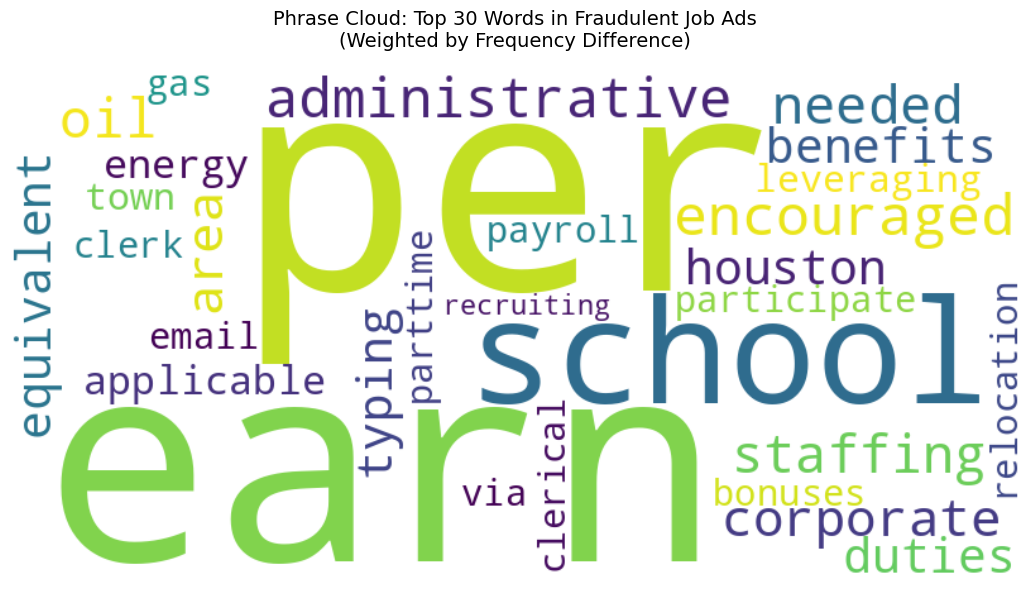

In [ ]:
#extract top 30 words with highest difference
top_words = word_df_sorted[['word', 'diff']].head(30)

#create dictionary of words and their weigts (difference)
phrase_weights = dict(zip(top_words['word'], top_words['diff']))

# generate word cloud with weights
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    collocations=False,  # **prevents repeated combinations
    prefer_horizontal=0.7,
    max_words=30,
).generate_from_frequencies(phrase_weights)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Phrase Cloud: Top 30 Words in Fraudulent Job Ads\n(Weighted by Frequency Difference)', fontsize=14, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

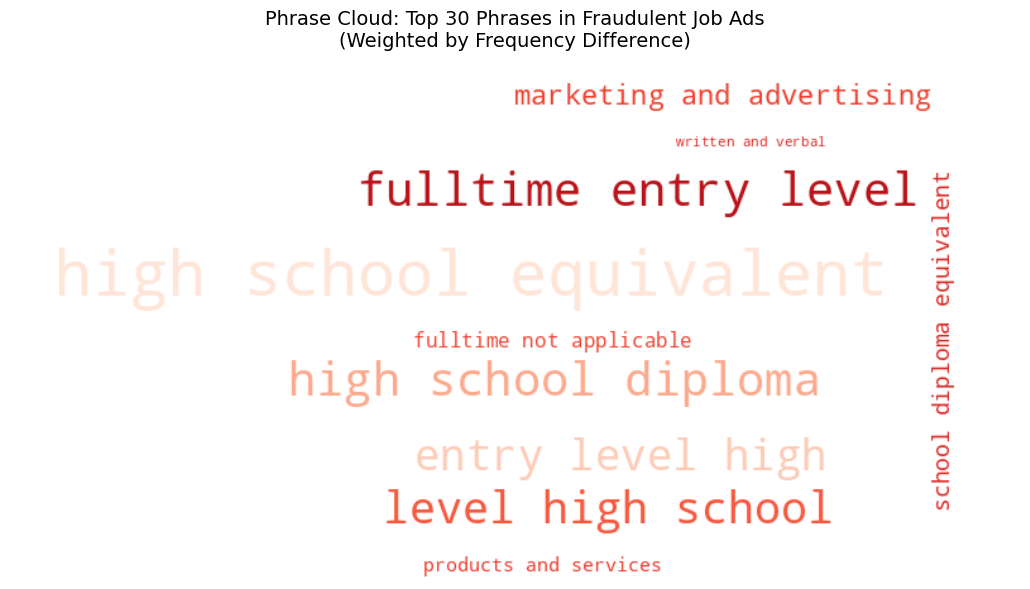

In [ ]:

# Extract top 30 phrases and use 'diff' (p_fraud - p_legit) as weight
top_phrases = phrase_df_sorted[['phrase', 'diff']].head(30)

# Create a dictionary of phrases and their weights
phrase_weights = dict(zip(top_phrases['phrase'], top_phrases['diff']))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    collocations=False,  # **prevents repeated combinations
    prefer_horizontal=0.7,
    max_words=30,
).generate_from_frequencies(phrase_weights)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Phrase Cloud: Top 30 Phrases in Fraudulent Job Ads\n(Weighted by Frequency Difference)', fontsize=14, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


# Data Preparation

## Data splitting

To build a reliable fraud detection model, the dataset was first cleaned using the `clean_df` function.

After cleaning, the features (`X`) and target (`y`) were separated:
- `X`: All job ad features **except** the `fraudulent` label (to prevent data leakage)
- `y`: Converted binary target where `'t'` => 1 (fraudulent), `'f'` => 0 (legitimate)

The data was then split into training and testing sets:
- **80% training**, **20% testing**
- **Stratified sampling** was used to preserve the proportion of fraudulent jobs (~4.8%) in both sets
- A fixed `random_state=42` ensures reproducibility

Finally, the cleaned text (`text_clean`) was extracted for use in text vectorization:
- `X_train_text`: Cleaned job ads for model training
- `X_test_text`: Cleaned job ads for evaluation

This process ensures the model learns from realistic patterns in the data and is evaluated fairly on unseen examples.

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('DataSet.csv')

df_clean = clean_df(df) 
#Drop answers
X = df_clean.drop('fraudulent', axis=1) # the predictor features to be dropped to prevent model from knowing answer in advance
y = df_clean['fraudulent'].map({'t': 1, 'f': 0})  # target: the correct answer the model needs to predict

# Stratified split into 20-80 & to preserve fraud ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

In [ ]:
train_df = clean_df(X_train.copy())
test_df = clean_df(X_test.copy())

X_train_text = train_df['text_clean']
X_test_text = test_df['text_clean']

## Feature Engineering

To build a robust fraud detection model, we combined **text-based features** with **domain-driven signals** , both derived from exploratory analysis.

Earlier, we identified **red_flag** features such as 
- **Missing Fields**. Having missing `significant_fields` correlates to fraudulent scam job ads
- **Top 30 Words & Phrases** most commonly used in scam job advertisements.
Therefore, as part of feature engineering, we will be introducing the `create_custom_features()` function which will incorporate these red flags into our dataset for training.

#### **Methodology**
We used `TfidfVectorizer` to convert job ad text into numerical features:
- **N-grams (1–2 words)**. Captures both individual terms and common phrases (e.g., "work from home")
- **Stop words removed**. Improves signal-to-noise ratio

The vectorizer was **fitted only on training data** (`X_train_text`) to prevent data leakage

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    stop_words='english'
)

# Fit on training data only****** to avoid data leakage
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [ ]:
def create_custom_features(df):
    features = pd.DataFrame(index=df.index)  # Each row corresponds to a job ad

    # 1. Missing significant fields
    for field in significant_fields.keys():
        # Check for empty, whitespace, 'nan', 'None', or actual NaN
        is_missing = (
            df[field].isna() |
            (df[field].astype(str).str.strip() == '') |
            (df[field].astype(str).str.lower() == 'nan') |
            (df[field].astype(str).str.lower() == 'none')
        )
        features[f'missing_{field}'] = is_missing.astype(int)

    # 2. Top 30 scam-associated words
    for word in word_df_sorted['word'].head(30):
        pattern = rf'\b{re.escape(word)}\b' # put word boundary to avoif partial matches
        features[f'has_word_{word}'] = df['text_clean'].str.contains(pattern, case=False, na=False).astype(int)

    # 3. Top 30 scam-associated phrases
    for phrase in phrase_df_sorted['phrase'].head(30):
        pattern = re.escape(phrase) # escape special characters in phrases such as # or , etc.
        pattern = rf'\b{pattern}\b' #exact match
        features[f'has_phrase_{phrase}'] = df['text_clean'].str.contains(pattern, case=False, na=False).astype(int)

    return features.values

In [ ]:
# Apply to both training and test data to standardise structure
X_train_custom = create_custom_features(train_df)
X_test_custom = create_custom_features(test_df)

print("Custom feature matrix shape:", X_train_custom.shape) 

Custom feature matrix shape: (14304, 66)


# Training

To build an effective fraud detection system, we trained a **Logistic Regression** model on a combined feature set that integrates both textual and behavioral signals.

#### Model Selection
We chose Logistic Regression because it is
- **Interpretable**. Coefficients show feature importance
- **Efficient** for high-dimensional text data
- **Suited for binary classification**
To address class imbalance (only ~4.8% fraudulent jobs), we used class_weight='balanced', which adjusts the penalty per class to improve detection of scams.

#### Feature Combination
The final feature matrix was created by combining:
- **Text features**: TF-IDF vectors from `text_clean`
- **Custom red flag features**: Binary indicators for missing fields, scam-associated words, and phrases

In [ ]:
from scipy.sparse import hstack

X_train_combined = hstack([X_train_tfidf, X_train_custom])
X_test_combined = hstack([X_test_tfidf, X_test_custom])

print("Final feature matrix shape:", X_train_combined.shape)

Final feature matrix shape: (14304, 5066)


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_combined, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Evaluation

To assess the performance of the trained Logistic Regression model, we evaluated its predictions on the unseen test set (`X_test_combined`). The evaluation focused on metrics that are meaningful for fraud detection, where the goal is to **catch as many scams as possible** while minimizing false alarms.

#### Key Metrics
- **Precision (Fraudulent)**: **56.6%**  
When the model flags a job ad as fraudulent, it is correct about 57% of the time. This means roughly 4 in 10 flagged jobs are legitimate (false positives).
  
- **Recall (Fraudulent)**: **89.6%**  
The model successfully identifies nearly 90% of actual scam job ads, which is critical for protecting job seekers.

- **F1-Score (Fraudulent)**: **0.69**  
A balanced measure of precision and recall, indicating strong overall performance despite class imbalance.

- **ROC-AUC**: **0.987** 
Receiver Operating Characteristic - Area Under Curve
Exceptional ability to distinguish between fraudulent and legitimate job ads.
i.e. If 1 fraudulent job and 1 normal job is randomly picked, there’s a 98% chance the model assigns a higher fraud probability to the fraudulent job.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score

######PREDICTIONS######
y_pred = model.predict(X_test_combined)
y_pred_proba = model.predict_proba(X_test_combined)[:, 1]  # probability of fraud

###### Key metrics ######
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nPrecision (how many flagged are real scams): {precision_score(y_test, y_pred):.3f}")
print(f"Recall (how many scams were caught): {recall_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      0.97      0.98      3403
  Fraudulent       0.57      0.90      0.69       173

    accuracy                           0.96      3576
   macro avg       0.78      0.93      0.84      3576
weighted avg       0.97      0.96      0.97      3576


Confusion Matrix:
[[3284  119]
 [  18  155]]

Precision (how many flagged are real scams): 0.566
Recall (how many scams were caught): 0.896
ROC-AUC: 0.987


In [56]:
# Get feature names
feature_names_tfidf = vectorizer.get_feature_names_out().tolist()
custom_feature_names = [
    f'missing_{field}' for field in significant_fields.keys()
] + [
    f'has_word_{word}' for word in word_df_sorted['word'].head(30)
] + [
    f'has_phrase_{phrase}' for phrase in phrase_df_sorted['phrase'].head(30)
]

feature_names = feature_names_tfidf + custom_feature_names

# Get coefficients
coefficients = model.coef_[0]

# Top 20 most predictive features
import pandas as pd
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', ascending=False).head(20)

print("\nTop Features Driving Fraud Prediction:")
print(feature_importance)


Top Features Driving Fraud Prediction:
                      feature  coefficient
1792                financing     4.242237
2576                     link     4.080954
2868                    money     3.883547
4349                 supplier     3.205435
178            administrative     2.904153
5000  missing_company_profile     2.842221
3025                     ohio     2.496881
1513              engineering     2.447947
2149                 hospital     2.438588
5023      has_word_leveraging     2.411890
1392                 duration     2.357136
4373                  systems     2.332522
968                  contract     2.317072
2916               nationwide     2.299789
659                    center     2.273547
2155                    hotel     2.272618
4084                     size     2.222710
651                      cash     2.213305
2102              high school     2.192023
828               communities     2.190148


In [ ]:
import joblib

### CACHE AND SAVE MODEL & VECTORIZER ###
joblib.dump(model, 'fraud_detection_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(significant_fields, 'significant_fields.pkl')  # For feature engineering

['significant_fields.pkl']

In [ ]:
def predict_fraud(job_text):
    # Clean the text
    cleaned = clean_html(job_text).lower()
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'[^\w\s]', '', cleaned)
    
    # Vectorize
    X_tfidf = vectorizer.transform([cleaned])
    
    # Create custom features to simulate a single-row df
    temp_df = pd.DataFrame({'text_clean': [cleaned]})
    for field in significant_fields.keys():
        temp_df[field] = ''  # assume missing if not present
    X_custom = create_custom_features(temp_df)
    
    # Combine
    X_final = hstack([X_tfidf, X_custom])
    
    # Predict
    pred = model.predict(X_final)[0]
    prob = model.predict_proba(X_final)[0][1]  # % chance it's fraud
    
    result = "Fraudulent" if pred == 1 else "Legitimate"
    confidence = prob * 100
    
    return result, f"{confidence:.1f}%"

#### Random Testing for predict_fraud

In [88]:
new_ad = X_test.iloc[1392]['text']
print(X_test.head())
result, conf = predict_fraud(new_ad)
print(f'Job Ad Text:', new_ad)
print(f"Prediction: {result}")
print(f'Percentage Chance of fraud: {conf}')
print(f'Actual Label:', 'Fraudulent' if y_test.iloc[1392] == '1' else 'Legitimate')

                                                   title  \
16995          EXCELLENT ER RN Opportunity Available Now   
9357   Scrum Master / Website Development Project Man...   
11561                            HR Assistant - Contract   
1105                Regional Sales Director South Africa   
1980                                     Petrophysicist    

                    location        department salary_range  \
16995         US, IL, Urbana                                  
9357           US, FL, Tampa                                  
11561        AU, NSW, Sydney  People & Culture                
1105    ZA, GT, Johannesburg             Sales                
1980   US, OK, Oklahoma City                                  

                                         company_profile  \
16995                                                      
9357   <p>352 Inc. is a full-service digital agency c...   
11561  <p>Squiz is one of the world's leading web sol...   
1105   <p>Upstream’s